# Cat-Dog Classification with MobileNet V1, V2 and V3

## 1. Giới thiệu

Mạng **MobileNet** lần đầu tiên được giới thiệu vào tháng 4 năm 2017 bởi nhóm nghiên cứu đến từ Google, với mục tiêu là tạo ra 1 mô hình gọn nhẹ, có thể chạy trên các thiết bị mobile, hệ thống nhúng với cấu hình hạn chế, cân bằng giữa tốc độ và độ chính xác ở mức chấp nhận được.

Trải qua quá trình phát triển, cho đến nay thì **MobileNet V3** là bản nâng cấp mới nhất cho mô hình này.

Link paper gốc: 
- [MobileNetV1](https://arxiv.org/abs/1704.04861)

Trong tutorial này, chúng ta sẽ áp dụng mô hình này cho bài toán phân loại ảnh chó mèo quen thuộc để so sánh hiệu năng với những thuật toán khác để có một cái nhìn trực quan nhất: 

Link dataset: 
- [Dog vs Cat Classification](https://www.kaggle.com/competitions/dog-vs-cat-classification)

## 2. Bộ dataset này có gì ? 

- Folder `test` : Gồm 8000 bức ảnh
- Folder `train` : 
    - Folder `dog` : 12500 bức ảnh được gán nhãn là "dog"
    - Folder `cat` : 12500 bức ảnh được gán nhãn là "cat"


In [1]:
!pip install -q kaggle 

# Get the token.json to download the dataset
!git clone https://github.com/BKAI-Team-Thay-Linh/Cat-dog-Classification-with-MobileNet

!mv Cat-dog-Classification-with-MobileNet/kaggle.json /Users/khacanh/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dog-vs-cat-classification

Cloning into 'Cat-dog-Classification-with-MobileNet'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), done.
Resolving deltas: 100% (1/1), done.
mv: rename Cat-dog-Classification-with-MobileNet/kaggle.json to /Users/khacanh/.kaggle/: No such file or directory
chmod: /Users/khacanh/.kaggle/kaggle.json: No such file or directory
Traceback (most recent call last):
  File "/Users/khacanh/anaconda3/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/khacanh/anaconda3/lib/python3.11/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/Users/khacanh/anaconda3/lib/python3.11/site-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure 

In [8]:
import zipfile

!unzip -q dog-vs-cat-classification.zip

## 3. Khám phá bộ data

In [9]:
!ls

Cat-dog-Classification-with-MobileNet  sample_submission.csv  train
dog-vs-cat-classification.zip	       test


Ta sẽ đi khảo sát 1 vòng tập `train` để xem kích thước của bộ dataset này như thế nào 

In [10]:
import os
from PIL import Image
import imghdr

train_cat_folder = os.path.join(os.getcwd(), 'train' , 'train', 'cats')
train_dog_folder = os.path.join(os.getcwd(), 'train' , 'train', 'dogs')

pic_info = {}
pics_dir = []

# Cat images
for cat_file in os.listdir(train_cat_folder):
    pics_dir.append(os.path.join(train_cat_folder, cat_file))

# Dog images
for dog_file in os.listdir(train_dog_folder):
    pics_dir.append(os.path.join(train_dog_folder, dog_file))

print(len(pics_dir))

25000


In [11]:
for img_path in pics_dir:
    with Image.open(img_path) as img:
        pic_info[os.path.basename(img_path)] = img.size

In [13]:
width = [shape[0] for shape in list(pic_info.values())]
height = [shape[1] for shape in list(pic_info.values())]

Bây giờ chúng ta sẽ khảo sát dimension của toàn bộ ảnh trong tập train:

In [14]:
import pandas as pd

dim_df = pd.DataFrame({'width': width, 'height': height})
dim_df.describe()

,width,height
count,25000.00000,25000.000000
mean,404.09904,360.478080
std,109.03793,97.019959
min,42.00000,32.000000
25%,323.00000,301.000000
50%,447.00000,374.000000
75%,499.00000,421.000000
max,1050.00000,768.000000


Theo bảng thống kê trên, ta có được một số nhận xét như sau:
- Chiều cao (H) trung bình của bức ảnh là 360.5, trong khi độ rộng trung bình (W) của bức ảnh sẽ là 404.1
- Bức ảnh lớn nhất sẽ có kích thước lên tới 1050x768 pixels trong khi bức ảnh nhỏ nhất chỉ có kích thước 42x32 pixels

Ta sẽ thử xem 2 bức ảnh đó trông như thế nào ? 

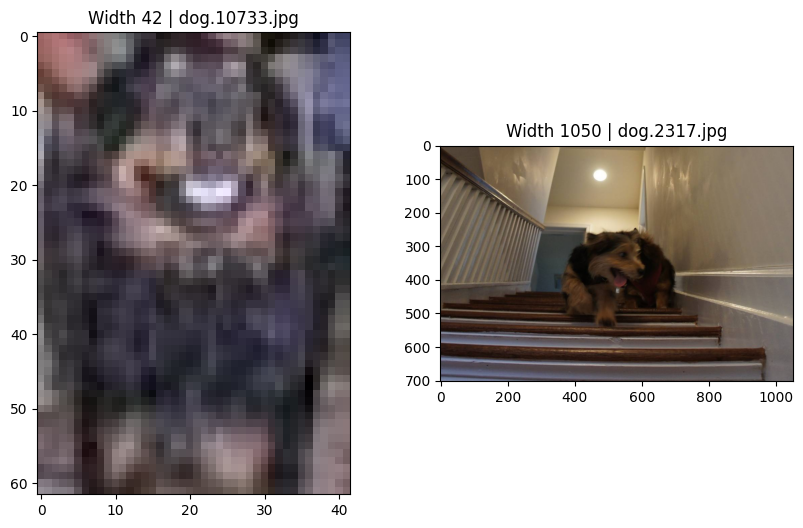

In [15]:
import matplotlib.image as mp_img
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,6))

for img_name, shape in pic_info.items():
    if shape[0] == 42:
        img_path = os.path.join(train_cat_folder, img_name) if os.path.exists(os.path.join(train_cat_folder, img_name)) else os.path.join(train_dog_folder, img_name)
        img = mp_img.imread(img_path)
        axs[0].imshow(img)
        axs[0].set_title(f'Width 42 | {img_name}')
    elif shape[0] == 1050:
        img_path = os.path.join(train_cat_folder, img_name) if os.path.exists(os.path.join(train_cat_folder, img_name)) else os.path.join(train_dog_folder, img_name)
        img = mp_img.imread(img_path)
        axs[1].imshow(img)
        axs[1].set_title(f'Width 1050 | {img_name}')

plt.show()
    

Một bức ảnh với chất lượng khá thấp và khó nhìn ra nó là chó hay mèo, trong khi bức ảnh còn lại có độ phân giải khá cao.

Ngoài ra, bằng việc quan sát thủ công, ta còn thấy được tập `train` có khả nhiều ảnh có nhiều vật thể ngoại lai chẳng hạn như con người, ...

## 4. Modelling

### 4.1 Import libraries

In [16]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### 4.2 Tiền xử lí dữ liệu và Data Augmentation

Ở bước này, ta phải chuyển những bức ảnh RGB về dạng `torch.Tensor` để đưa vào model. Quy trình như sau:
- Resize bức ảnh về kích thước 112x112 sử dụng `torchvision.transforms.Resize()`
- Đưa bức ảnh về `torch.Tensor` sử dụng `transforms.ToTensor()`
- 

In [17]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((112, 112)),
        transforms.ToTensor()
    ]
)

In [18]:
train_data = datasets.ImageFolder()

TypeError: ImageFolder.__init__() missing 1 required positional argument: 'root'